In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import gensim
import numpy as np
import json
from brand.debiasing import EmbeddingDebias
from brand.utils import get_embedding_mat, get_word_vector

# load definition words
gender_cfg_file = '../vocab/gender.json'
with open(gender_cfg_file, 'r') as f:
    cfg = json.load(f)
    gender_ds = cfg['definite_sets']

country_cfg_file = '../vocab/country_us_china.json'
with open(country_cfg_file, 'r') as f:
    cfg = json.load(f)
    country_ds = cfg['definite_sets']

In [2]:
# load word vector model
pretrained_embedding_file = '../data/GoogleNews-vectors-negative300.bin.gz'
kv = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embedding_file, binary=True, limit=500000)

In [3]:
# prepare definitial (direction) matrix
gender_dmat = []
for _, words in enumerate(gender_ds):
    mat = get_embedding_mat(words, kv)
    gender_dmat.append(np.asarray(mat))

country_dmat = []
for _, words in enumerate(country_ds):
    mat = get_embedding_mat(words, kv)
    country_dmat.append(np.asarray(mat))

In [4]:
# create two debiasing workers
method = 'Hard'
k = 1
gender_debias = EmbeddingDebias(gender_dmat, embedding=kv, k=k, method=method)
country_debias = EmbeddingDebias(country_dmat, embedding=kv, k=k, method=method)

In [5]:
# dot product between two direction vectors
print('Dot product between two directions:', gender_debias._B.reshape(-1,).dot(country_debias._B.reshape(-1,)))

Dot product between two directions: -0.055169642


In [6]:
# brand list:
brands_China = ['Lenovo', 'Huawei', 'Alibaba', 'Lining', 'Anta', 'Haier', 'Hisense', 'Netease', 'Baidu', 'Sina']
brands_US = ['Google', 'Apple',  'Amazon', 'Microsoft', 'Marlboro', 'Outlier', 'Reformation','Pacifica', 'Sephora', 'Zippo', 'Cartier', 'UGG']

# check whether these words has pre-trained embeddings in w2vNews
for brand in brands_China+brands_US:
    try:
        embedding = kv[brand]
    except:
        print('{} not found.'.format(brand))
        continue

In [7]:
# project onto the gender-country plane
brands = brands_China + brands_US
_, mean = get_embedding_mat(brands, kv, mean=True)

gender_direction = gender_debias._B.reshape(-1,)
country_direction = country_debias._B.reshape(-1,)
c_gender = []
c_country = []
for brand in brands:
    coordinate_gender = get_word_vector(brand, kv, mean).dot(gender_direction)
    coordiante_country = get_word_vector(brand, kv, mean).dot(country_direction)
    c_gender.append(coordinate_gender)
    c_country.append(coordiante_country)
print(c_gender)
print(c_country)

[0.07047207, -0.3708894, 0.05607707, -0.33665416, -0.29115945, -0.15549654, -0.19084011, -0.0386585, 0.113841936, 0.118801445, 0.16688912, -0.032072615, 0.40479356, -0.108087435, -0.2588839, -0.15374503, -0.06145732, 0.022524446, 0.72377574, -0.2690172, 0.25608873, 0.33369744]
[-0.5894716, -0.4123206, -1.2011464, 0.44843948, -0.124019, -0.5182568, -0.7342663, -1.3253696, -1.2976283, -0.40149066, -0.19519573, 0.104717344, 0.49755576, 0.32424748, 0.7361896, 0.8254723, 0.79437464, 0.8112071, 0.6807859, 0.38006404, 0.52958834, 0.6665229]


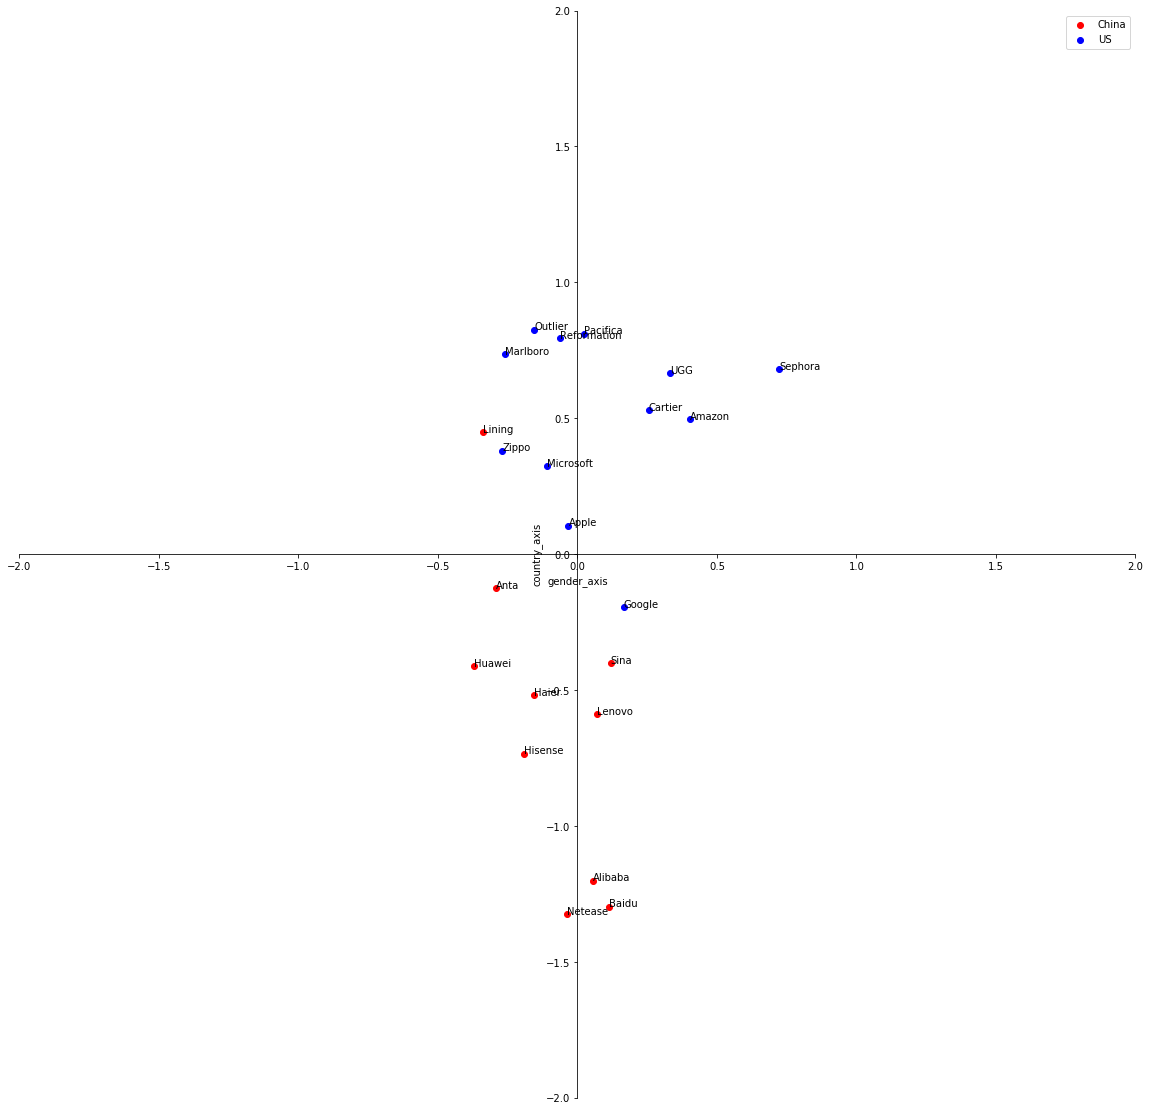

In [8]:
# plot on the gender-country 2D plane
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('gender_axis')
ax.set_ylabel('country_axis')
split = len(brands_China)
ax.scatter(x=c_gender[:split], y=c_country[:split], c='r', label='China')
ax.scatter(x=c_gender[split:], y=c_country[split:], c='b', label='US')
brands = brands_China + brands_US
for i, brand in enumerate(brands):
    ax.annotate(brand, (c_gender[i], c_country[i]))
ax.legend()
fig.savefig('../figures/gender_vs_country(China-US).png')
plt.show()

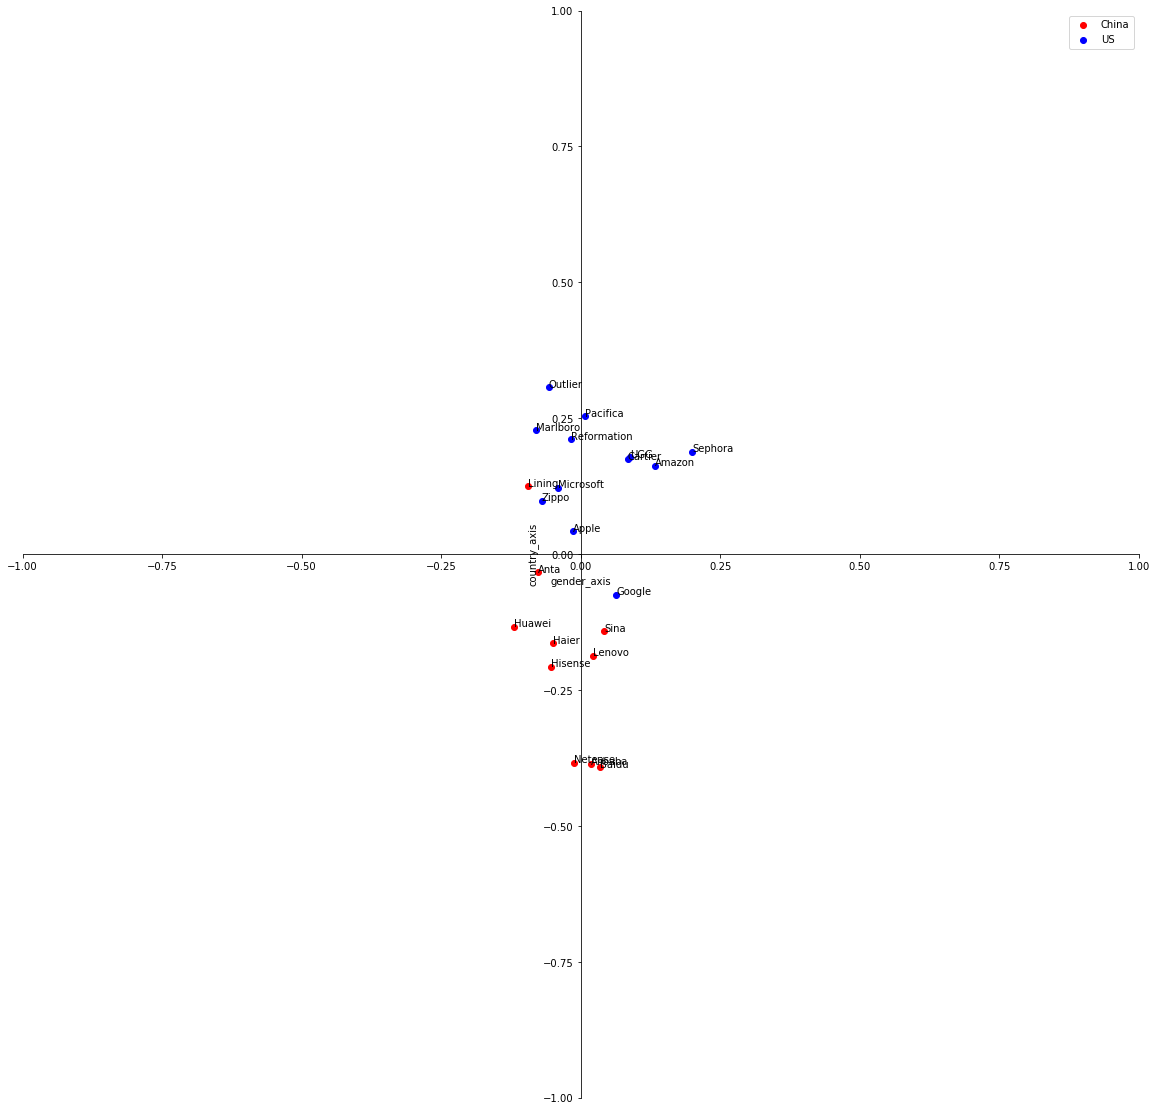

In [11]:
# plot using unit length
# project onto the gender-country plane
brands = brands_China + brands_US
gender_direction = gender_debias._B.reshape(-1,)
country_direction = country_debias._B.reshape(-1,)
c_gender_unit = []
c_country_unit = []
for brand in brands:
    vec = get_word_vector(brand, kv, mean)
    coordinate_gender = vec.dot(gender_direction) / (np.linalg.norm(vec) * np.linalg.norm(gender_direction))
    coordiante_country = vec.dot(country_direction) / (np.linalg.norm(vec) * np.linalg.norm(country_direction))
    c_gender_unit.append(coordinate_gender)
    c_country_unit.append(coordiante_country)

# plot on the gender-country 2D plane
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 20))

ax2.spines['left'].set_position('zero')
ax2.spines['bottom'].set_position('zero')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_xlabel('gender_axis')
ax2.set_ylabel('country_axis')
split = len(brands_China)
ax2.scatter(x=c_gender_unit[:split], y=c_country_unit[:split], c='r', label='China')
ax2.scatter(x=c_gender_unit[split:], y=c_country_unit[split:], c='b', label='US')
brands = brands_China + brands_US
for i, brand in enumerate(brands):
    ax2.annotate(brand, (c_gender_unit[i], c_country_unit[i]))
ax2.legend()
fig2.savefig('../figures/gender_vs_country(China-US)_unit_len.png')

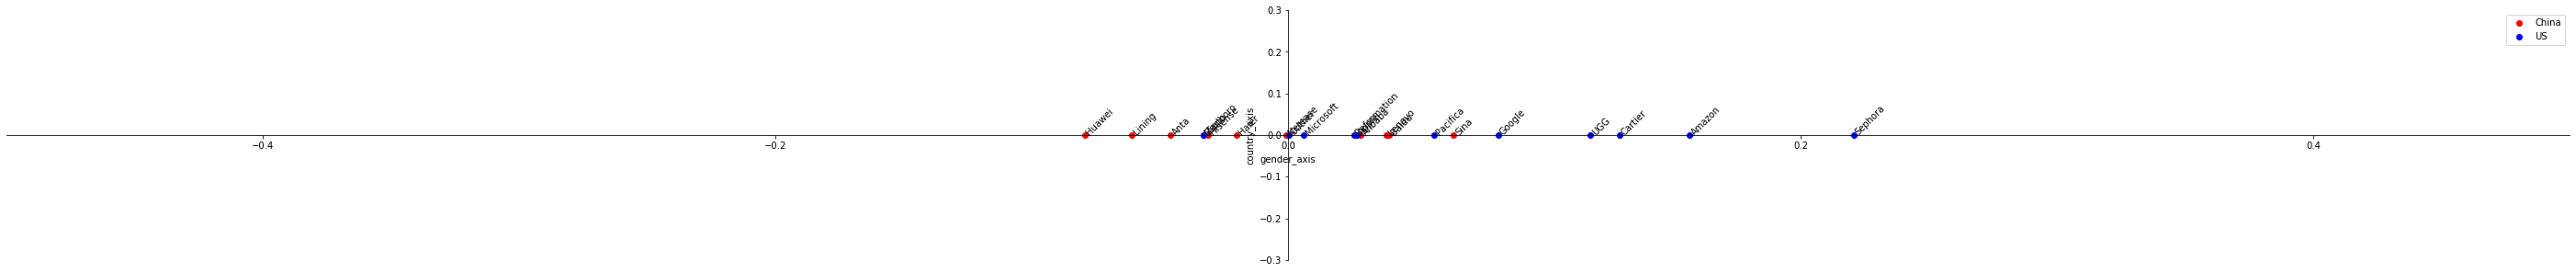

In [10]:
# debias country, check gender
brands = brands_China + brands_US
_, embedding_debiased, _ = country_debias.debiasing(words=brands, eq_sets=country_ds)

c_gender_unit_country_debiased = []
c_country_unit_country_debiased = []
for i, brand in enumerate(brands):
    coordinate_gender = embedding_debiased[i].dot(gender_direction) / (np.linalg.norm(embedding_debiased[i]) * np.linalg.norm(gender_direction))
    coordiante_country = embedding_debiased[i].dot(country_direction) / (np.linalg.norm(embedding_debiased[i]) * np.linalg.norm(country_direction))
    c_gender_unit_country_debiased.append(coordinate_gender)
    c_country_unit_country_debiased.append(coordiante_country)

# plot on the gender-country 2D plane
fig3, ax3 = plt.subplots(1, 1, figsize=(50, 5))

ax3.spines['left'].set_position('zero')
ax3.spines['bottom'].set_position('zero')
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')

ax3.set_xlim(-0.5, 0.5)
ax3.set_ylim(-0.3, 0.3)
ax3.set_xlabel('gender_axis')
ax3.set_ylabel('country_axis')
split = len(brands_China)
ax3.scatter(x=c_gender_unit_country_debiased[:split], y=c_country_unit_country_debiased[:split], c='r', label='China')
ax3.scatter(x=c_gender_unit_country_debiased[split:], y=c_country_unit_country_debiased[split:], c='b', label='US')
brands = brands_China + brands_US
for i, brand in enumerate(brands):
    ax3.annotate(brand, (c_gender_unit_country_debiased[i], c_country_unit_country_debiased[i]), rotation=45)
ax3.legend()
fig3.savefig('../figures/gender_vs_country(China-US)_unit_len_country_debiased.png')